In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import numpy as np
#import keras
from tensorflow import keras
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, GlobalAveragePooling2D, MaxPooling2D,Softmax
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
import random
from tensorflow.keras import utils as np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D
import datetime
from time import time
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.layers.pooling import GlobalAveragePooling2D
import sys
sys.path.append("/home/ecbm4040/Final_Project/e4040-2021Fall-Project-SCNN-as6430-as6456-vsk2123/src/")




In [3]:
# CIFAR10 Dataset
from modules.utils import load_data
X_train, y_train = load_data(mode='train')
num_training = 49000
num_validation = 1000

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data, and reshape it to be RGB size
mean_image = np.mean(X_train, axis=0)
X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image

X_train = X_train.reshape(-1,3,32,32).transpose(0,2,3,1) / 255
X_val = X_val.reshape(-1,3,32,32).transpose(0,2,3,1) / 255

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)

y_train_dummy = tf.keras.utils.to_categorical(y_train)
y_val_dummy = tf.keras.utils.to_categorical(y_val)
print('Train labels shape (one-hot): ', y_train_dummy.shape)
print('Validation labels shape (one-hot): ', y_val_dummy.shape)

./data/cifar-10-python.tar.gz already exists. Begin extracting...
Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Train labels shape (one-hot):  (49000, 10)
Validation labels shape (one-hot):  (1000, 10)


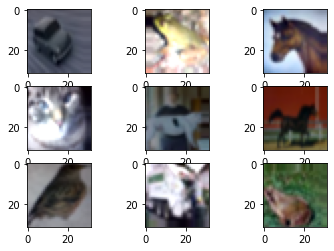

In [4]:
# Data augmentation code

def HSV_perturbations(image):
    """
    Takes an input image and returns it with either the randomly adjusted hue or saturation
    (or may be makes no HSV change at all) with a probability of 1/3
    """
    choice=random.randint(1,3)
    print(choice)
    image = np.array(image)
    if choice ==1:
        return tf.image.random_hue(image, 1/random.randint(1,10))
    elif choice ==2:
        return tf.image.random_saturation(image, 5, 10)
    else:
        return image # so as to avoid not change hue for every image

datagen = ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.5,1.5]
    )
datagen.fit(X_train)

# Plot sample augmented images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].astype(np.uint8))
    plt.show()
    break

In [5]:
from modules.layers import spectralConv2D


def spectralCNN(input_shape):

    
    model = Sequential()
    model.add(spectralConv2D(96, kernel_size=(3,3),padding="VALID",strides=(1,1), input_shape=input_shape))
    model.add(spectralConv2D(96, kernel_size=(3,3),padding="VALID",strides=(1,1)))
    model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

    model.add(spectralConv2D(192, kernel_size=(3,3),padding="VALID",strides=(1,1)))
    model.add(spectralConv2D(192, kernel_size=(3,3),padding="VALID",strides=(1,1)))
    model.add(spectralConv2D(192, kernel_size=(3,3),padding="VALID",strides=(1,1)))        
    model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
    
    model.add(spectralConv2D(192, kernel_size=(1,1),padding="VALID",strides=(1,1)))
    model.add(spectralConv2D(10, kernel_size=(1,1),padding="VALID",strides=(1,1)))   
    model.add(GlobalAveragePooling2D())     
    model.add(Softmax()) 
        
    model = Sequential()


    return model
    


In [6]:
batch_size=128
nb_epochs=50
output_size=10

train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)
valid_generator = datagen.flow(X_val, y_val, batch_size=batch_size)

spectral_cnn_model = spectralCNN(X_train.shape[1:])
spectral_cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history=spectral_cnn_model.fit_generator(train_generator,epochs=nb_epochs,steps_per_epoch=len(X_train)//batch_size, validation_data=valid_generator)

/home/ecbm4040/envTF24/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50


InvalidArgumentError:  logits and labels must have the same first dimension, got logits shape [131072,3] and labels shape [128]
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at <ipython-input-6-c34f95993e19>:10) ]] [Op:__inference_train_function_285]

Function call stack:
train_function


In [ ]:
y_train

In [ ]:
import matplotlib.pyplot as plt 
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()